# OpenFE - Planning Free energy transformations

In this notebook we are going to have a look on the current status of the OpenFE package, how transformation networks for relative free energy calculations are planned.
from openfe import setup

## First things first the input:

Let's first load a molecule of choice into the OpenFe-Environment. 

In [ ]:
from rdkit import Chem
from openfe import SmallMoleculeComponent

# Starting from Smiles in a dictionary:
name_smiles  = [
('phenol', 'c1ccccc1O'),
('catechol', 'c1cccc(O)c1O'),
]

rd_mols = [Chem.MolFromSmiles(s) for n,s in name_smiles]
rd_mols = [Chem.AddHs(m, addCoords=True) for m in rd_mols]
[Chem.rdDistGeom.EmbedMultipleConfs(m, 1) for m in rd_mols]
[m.SetProp("_Name", n) for (n,s),m in zip(name_smiles, rd_mols)]

# Bring rdkit to openfe:
mols = [SmallMoleculeComponent(m, name=n) for (n,s),m in zip(name_smiles, rd_mols)]

Chem.Draw.MolsToGridImage(rd_mols, molsPerRow=6)


## Step One - Generating Atom Mappings

With the loaded Molecules, we can now go to the first step an start to generate possible atom mappings for the different transformations.

Let's start with a single mapping.

In [ ]:
from openfe.utils.visualization_3D import show_component_coords
from kartograf.atom_mapping.geom_align import align_molB_to_molA_sceletons

molA = mols[0]
molB = mols[1]
molB = align_molB_to_molA_sceletons(molA=molA, molB=molB)
show_component_coords([molA, molB])


In [ ]:
from openfe import setup

lomap_mapper = setup.LomapAtomMapper()

mapping = next(lomap_mapper.suggest_mappings(molA, molB))
mapping

In [ ]:
from openfe.utils.visualization_3D import show_3D_mapping
show_3D_mapping(mapping)

### Lomap and GeomAtomMapper of Kartograf: 

This part want to showcase differences between Lomap and the GeomAtomMapper of Kartograf.

1. Stereo Center - Flips
first we show here a very simple case of stereocenter flip as an example of how to use Kartograf and Lomap.

In [ ]:
from rdkit import Chem

from openfe import SmallMoleculeComponent, setup
from openfe.utils.visualization_3D import show_component_coords, show_3D_mapping
from kartograf.atom_mapping.geom_align import align_molB_to_molA_sceletons


smiles = [ "C[C@H](F)Br",
          "C[C@@H](F)Br",
          ]

rd_mols = [Chem.MolFromSmiles(s) for s in smiles]
rd_mols = [Chem.AddHs(m, addCoords=True) for m in rd_mols]
[Chem.rdDistGeom.EmbedMultipleConfs(m, 1) for m in rd_mols]
mols = [SmallMoleculeComponent(m) for m in rd_mols]
align_molB_to_molA_sceletons(molA=mols[0], molB=mols[1])
show_component_coords(mols, _shift_components=[5,0,0])

In [ ]:
#Do mapping with Lomap:
lomap_mapper = setup.LomapAtomMapper()
lomap_mapping = next(lomap_mapper.suggest_mappings(mols[0], mols[1]))

# #Do mapping with Kartograf:
geom_atom_mapper = setup.GeomAtomMapper(atom_map_hydrogens=True)
kartograf_mapping = next(geom_atom_mapper.suggest_mappings(mols[0], mols[1]))

print(lomap_mapping.componentA_to_componentB)
lomap_mapping

In [ ]:
show_3D_mapping(lomap_mapping)

In [ ]:
print(kartograf_mapping.componentA_to_componentB)
kartograf_mapping

In [ ]:
show_3D_mapping(kartograf_mapping)

## Step Two - Atom Mapping Scoring
How can we compare different mappings? 

In [ ]:
#Number of mapped atoms:
print("Mapping comparisons")
n_lomap = len(lomap_mapping.componentA_to_componentB)
n_kartograf = len(kartograf_mapping.componentA_to_componentB)
print(f"Lomap mapped atoms: {n_lomap}")
print(f"Kartograf mapped atoms: {n_kartograf}")


# Getting the distances of the mapped atoms:
print("\n geometric measures")
lomap_dist = lomap_mapping.get_distances()
kartograf_dist = kartograf_mapping.get_distances()
print(f"Lomap atom distances: {lomap_dist}")
print(f"Kartograf atom distances: {kartograf_dist}")

import numpy as np
lomap_atom_avg_dist = np.mean(lomap_dist)
lomap_atom_avg_std = np.std(lomap_dist)
kartograf_atom_avg_dist = np.mean(kartograf_dist)
kartograf_atom_avg_std = np.std(kartograf_dist)
print("Avg distace of Lomap mapping: {:.2f} +- {:.2f}".format(lomap_atom_avg_dist, lomap_atom_avg_std))
print("Avg distace of Kartograf mapping: {:.2f} +- {:.2f}".format(kartograf_atom_avg_dist, kartograf_atom_avg_std))

In [ ]:
from openfe.setup import lomap_scorers

lomap_lomap_score = np.round(lomap_scorers.default_lomap_score(lomap_mapping),2)
kartograf_lomap_score = np.round(lomap_scorers.default_lomap_score(kartograf_mapping),2)

print("Lomap scores: ")
print("Lomap mapping: ", lomap_lomap_score)
print("Kartograf mapping: ", kartograf_lomap_score)

In [ ]:
from kartograf.atom_mapping import geom_scorer

lomap_lomap_score = np.round(geom_scorer.mappings_rms(lomap_mapping),2)
kartograf_lomap_score = np.round(geom_scorer.mappings_rms(kartograf_mapping),2)

print("Lomap scores: ")
print("Lomap mapping: ", lomap_lomap_score)
print("Kartograf mapping: ", kartograf_lomap_score)

In [ ]:
from kartograf.atom_mapping import geom_scorer

lomap_lomap_score = np.round(geom_scorer.mapping_volume_ratio(lomap_mapping),2)
kartograf_lomap_score = np.round(geom_scorer.mapping_volume_ratio(kartograf_mapping),2)

print("Lomap scores: ")
print("Lomap mapping: ", lomap_lomap_score)
print("Kartograf mapping: ", kartograf_lomap_score)

## Step Three - Building Networks
finally we can build transformation networks from the mappings and the scoring functions. These are the starting point for any free energy calculation. 

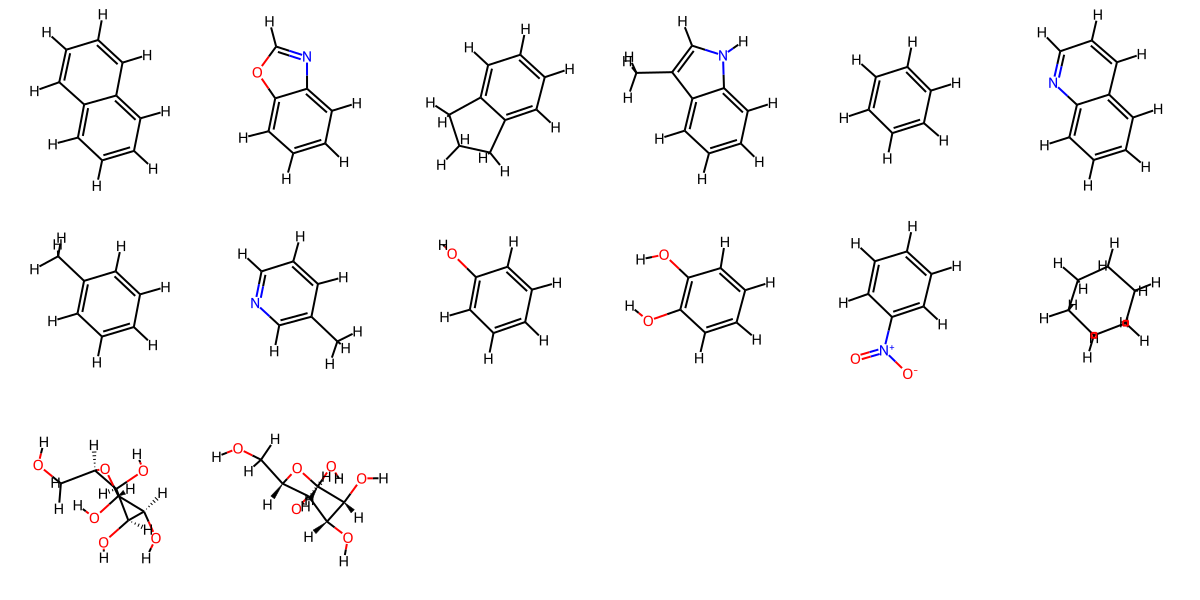

In [33]:
# Build Molecules:
from rdkit import Chem
from openfe import SmallMoleculeComponent
from kartograf.atom_mapping.geom_align import align_molB_to_molA_sceletons

# Starting from Smiles in a dictionary:
name_smiles  = [
('naphthalene', 'c12ccccc1cccc2'),
('benzoxazole', 'n1c2ccccc2oc1'),
('indane', 'c1ccc2c(c1)CCC2'),
('skatole', 'CC1=CNC2=CC=CC=C12'),
('benzene', 'c1ccccc1'),
('quinoline', 'n1cccc2ccccc12'),
('toluene', 'c1ccccc1C'),
('methylpyridine', 'c1ccncc1C'),
('phenol', 'c1ccccc1O'),
('catechol', 'c1cccc(O)c1O'),
('nitrobenzene', 'C1=CC=C(C=C1)[N+](=O)[O-]'),
('cyclohexane', 'C1CCCCC1'),
('d-glucose', '[C@H](CO)1[C@@H](O)[C@H](O)[C@H](O)[C@H](O)O1'),
('l-glucose', '[C@@H](CO)1[C@H](O)[C@@H](O)[C@@H](O)[C@@H](O)O1'),

]

rd_mols = [Chem.MolFromSmiles(s) for n,s in name_smiles]
rd_mols = [Chem.AddHs(m, addCoords=True) for m in rd_mols]
[Chem.rdDistGeom.EmbedMultipleConfs(m, 1) for m in rd_mols]
[m.SetProp("_Name", n) for (n,s),m in zip(name_smiles, rd_mols)]

# Bring rdkit to openfe:
mols = [SmallMoleculeComponent(m, name=n) for (n,s),m in zip(name_smiles, rd_mols)]
[align_molB_to_molA_sceletons(molA=mols[4], molB=mol) for mol in mols]
Chem.Draw.MolsToGridImage(rd_mols, molsPerRow=6)


In [34]:
# build a simple transformation network:
from openfe import setup
from openfe.setup import  ligand_network_planning
from openfe.setup.atom_mapping.lomap_scorers import default_lomap_score
from kartograf.atom_mapping.geom_scorer import mapping_volume_ratio

ligand_network_kartograf = ligand_network_planning.generate_minimal_spanning_graph(ligands=mols,
                                                        mappers=[setup.GeomAtomMapper()],
                                                        scorer=mapping_volume_ratio)

ligand_network_lomap = ligand_network_planning.generate_minimal_spanning_graph(ligands=mols,
                                                        mappers=[setup.LomapAtomMapper()],
                                                        scorer=default_lomap_score)

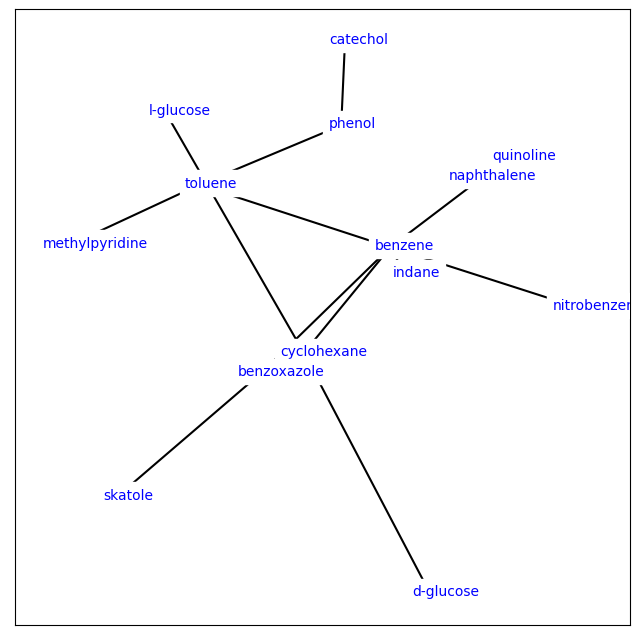

In [35]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network_lomap)

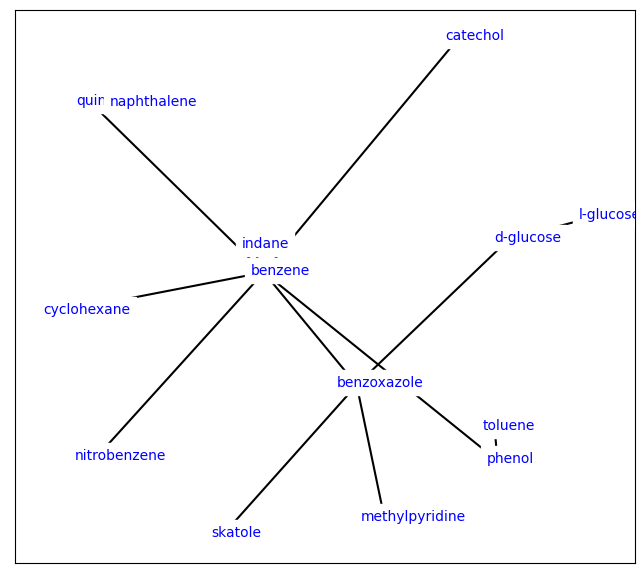

In [36]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network_kartograf)
